In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 内建的RNN层

In [2]:
model = keras.Sequential()
# 增加一个Embedding层，使得输入词汇量1000，输出embedding维度为64
model.add(keras.layers.Embedding(input_dim=1000, output_dim=64))

# 增加一个有128个内部单元的LSTM层
model.add(layers.LSTM(128))

# 10个单元的全连接层
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


## 输出与状态

通常RNN的输出层包含一个每个样本简单向量。该向量与最后的时间步相关，包含整个输入序列的信息。

输出的形状为 `(batch_size, units)`。RNN层通过设置`return_sequences=True`可以返回整个序列 `(batch_size, timesteps, units)`

In [3]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# GRU的输出为3D tensor，形状为 (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# SimpleRNN的输出为2D tensor (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
gru (GRU)                    (None, None, 256)         247296    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


此外，RNN层可以返回其最终的内部状态，可以用于重新执行RNN，或者初始化其他RNN。通常用于encoder-decoder的sequence-to-sequnce模型。

配置RNN返回内部状态需要在创建层时设置参数 `return_state=True`。LSTM有2个状态张量，而GRU只有1个。

配置层的初始state，调用额外参数`initial_state`。注意shape需要匹配unit的大小。

In [4]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(encoder_input)      # 两个括号表明前者会返回一个函数

# 输出以外还会返回states
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(encoder_embedded)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(decoder_input)

# 将2个states送入新的LSTM层，作为初始state
decoder_output = layers.LSTM(64, name="decoder")(decoder_embedded, initial_state=encoder_state)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     64000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 64)     128000      input_2[0][0]                    
______________________________________________________________________________________________

## RNN layers 与 RNN cells

RNN API还提供cell级别的API。RNNceng处理输入序列的整个batch，但是RNN cell只处理单个时间步。

cell在RNN层的`for`循环内。`keras.layers.RNN`封装了cell，使得能够处理序列批次。例如`RNN(LSTMCell(10))`。

`RNN(LSTMCell(10)`与`LSTM(10)`产生相同的结果。使用内建测`GRU`和`LSTM`层能够使用CuDNN，从而获得更好的表现。

有三种内建的RNN cell，与其对应的RNN层匹配：

* `keras.layers.SimpleRNNCell`
* `keras.layers.GRUCell`
* `keras.layers.LSTMCell`

抽象Cell与通用RNN类结合能够容易自定义RNN结构。

## Cross-batch statefulness

处理非常长的序列（可能无限长）时，使用。

通常，RNN层的内部状态在每次看见新的批次数据时都会重置（即 层所见的样本都认为与过去的是独立的）。只有处理给定样本时，网络层才会保留state。

当有非常的序列时，需要将其截断成较短的序列输入到RNN层，并且不重置网络层的state。使得网络层获得整个序列的信息。

通过在构造函数中设置`stateful=True`。

例如

```python
s = [t0, t1, ..., t1546, t1547]
s1 = [t0, t1, ..., t100]
s2 = [t101, ..., t201]
...
s16 = [t1501, ..., t1547]

lstm_layer = layers.LSTM(64, stateful=True)
for s in sub_sequences:
    output = lstm_layer(s)
```

使用`layer.reset_states()`来清空state。

In [5]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

lstm_layer.reset_states()

### RNN状态重用

RNN层的记录states并不包括`layers.weights()`。使用`layer.states`重用state值，在新模型层中使用`new_layer(inputs, initial_state=layer.states)`或者模型的子类。

此处没有使用序列模型，因为序列模型只支持单输入和单输出。

In [6]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)

existing_state = lstm_layer.states

new_lstm_layer = layers.LSTM(64)
new_output = new_lstm_layer(paragraph3, initial_state=existing_state)

## 双向RNN

除了时序以外的序列（例如文本），RNN模型不仅从头到尾处理能表现较好，反向也行。例如，预测句子中的下一个词，可以使用该词上下文，不仅只使用之前的词。

In [7]:
model = keras.Sequential()

model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10)))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 128)            38400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


## 结果优化与CuDNN核

TF 2.0内建的LSTM与GRU能够默认使用CUDNN核。

改变内建LSTM和GRU的一些默认值会使得无法使用CuDNN核。

### 可用时，使用CuDNN核

使用MNIST的每行作为一个输入序列，预测标签。

In [8]:
batch_size = 64
# 每个MNIST图像批次是一个 (batch_size, 28, 28) 的张量
# 输入序列为 (28, 28)（高度被视为时间）
input_dim = 28

units = 64
output_size = 10        # 标签 0-9

# 构建RNN模型
def build_model(allow_cudnn_kernel=True):      # 因为俺是没有独显的机器上跑的
    # CuDNN只在网络层级可用，cell级不可用
    # 即 `LSTM(units)` 会使用CuDNN，但 `RNN(LSTMCell(units))` 不会使用
    if allow_cudnn_kernel:
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # 将LSTMCell封装在RNN层就不会使用CuDNN
        lstm_layer = keras.layers.RNN(keras.layers.LSTMCell(units), input_shape=(None, input_dim))

    model = keras.models.Sequential([lstm_layer, keras.layers.BatchNormalization(), keras.layers.Dense(output_size)])
    return model

In [9]:
# 载入MNIST数据集
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

使用`sparse_categorical_crossentropy`作为模型的损失函数。模型的输出为`[batch_size, 10]`。

In [12]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)

model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1)

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 19s 314us/sample - loss: 0.9643 - accuracy: 0.6957 - val_loss: 0.5855 - val_accuracy: 0.8227


预测结果为：[3]，目标结果为：5


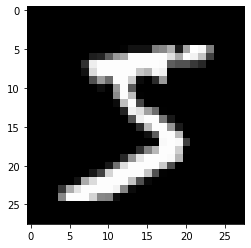

In [13]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print("预测结果为：%s，目标结果为：%s" %(result.numpy(), sample_label))
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

## list/dict输入或者嵌套输入的RNN